In [1]:

# STEP 1: Install required packages
!pip install neurokit2 wfdb heartpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 whi

In [28]:
# STEP 2: Import libraries with proper naming
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sp_signal  # Renamed to avoid conflict
from google.colab import drive
import heartpy as hp
import json

# STEP 3: Mount Google Drive to access ECG dataset
drive.mount('/content/drive')

# STEP 4: Load ECG signal from MIT-BIH
record_path = '/content/drive/MyDrive/dataset/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/105'
record = wfdb.rdrecord(record_path)
ecg_signal = record.p_signal[:, 0]  # Lead II
fs = record.fs  # Sampling rate (Hz)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# STEP 5: Implement paper's method with corrected naming

# 1. FIR Bandpass Filter (3-45 Hz)
def fir_bandpass_filter(ecg_signal, fs, lowcut=3.0, highcut=45.0, numtaps=101):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    taps = sp_signal.firwin(numtaps, [low, high], pass_zero=False)
    filtered_ecg = sp_signal.lfilter(taps, 1.0, ecg_signal)
    return filtered_ecg

filtered_ecg = fir_bandpass_filter(ecg_signal, fs)

# 2. R-peak detection using Hamilton segmenter (similar to paper)
def detect_r_peaks(filtered_ecg, fs):
    # Using HeartPy's Hamilton detector which is similar to the paper's approach
    wd, m = hp.process(filtered_ecg, sample_rate=fs)
    r_peaks = np.array(wd['peaklist'])
    return r_peaks

r_peaks = detect_r_peaks(filtered_ecg, fs)

# 3. Detect Q, S, P, T points relative to R-peaks
def detect_pqrst_points(filtered_ecg, r_peaks, fs):
    q_peaks = []
    s_peaks = []
    p_peaks = []
    t_peaks = []

    for r_peak in r_peaks:
        # Q wave detection (80ms before R peak)
        q_window_start = max(0, r_peak - int(0.08 * fs))
        q_window = filtered_ecg[q_window_start:r_peak]
        if len(q_window) > 0:
            q_peak = q_window_start + np.argmin(q_window)
            q_peaks.append(q_peak)

        # S wave detection (80ms after R peak)
        s_window_end = min(len(filtered_ecg), r_peak + int(0.08 * fs))
        s_window = filtered_ecg[r_peak:s_window_end]
        if len(s_window) > 0:
            s_peak = r_peak + np.argmin(s_window)
            s_peaks.append(s_peak)

        # P wave detection (200ms before Q peak, if Q was found)
        if len(q_peaks) > 0 and q_peaks[-1] is not None:
            p_window_start = max(0, q_peaks[-1] - int(0.2 * fs))
            p_window = filtered_ecg[p_window_start:q_peaks[-1]]
            if len(p_window) > 0:
                p_peak = p_window_start + np.argmax(p_window)
                p_peaks.append(p_peak)

        # T wave detection (400ms after S peak, if S was found)
        if len(s_peaks) > 0 and s_peaks[-1] is not None:
            t_window_end = min(len(filtered_ecg), s_peaks[-1] + int(0.4 * fs))
            t_window = filtered_ecg[s_peaks[-1]:t_window_end]
            if len(t_window) > 0:
                t_peak = s_peaks[-1] + np.argmax(t_window)
                t_peaks.append(t_peak)

    return {
        'ECG_R_Peaks': r_peaks,
        'ECG_Q_Peaks': np.array(q_peaks),
        'ECG_S_Peaks': np.array(s_peaks),
        'ECG_P_Peaks': np.array(p_peaks),
        'ECG_T_Peaks': np.array(t_peaks)
    }

info = detect_pqrst_points(filtered_ecg, r_peaks, fs)

Number of ground truth R-peaks: 2572
Number of detected R-peaks: 2639

R-Peak Detection Accuracy Metrics:
--------------------------------
True Positives (TP): 2546
False Negatives (FN): 26
False Positives (FP): 93
Accuracy: 0.9899 (98.99%)
Sensitivity (Se): 0.9899 (98.99%)
Positive Predictivity (+P): 0.9648 (96.48%)
Detection Error Rate (DER): 0.0463 (4.63%)


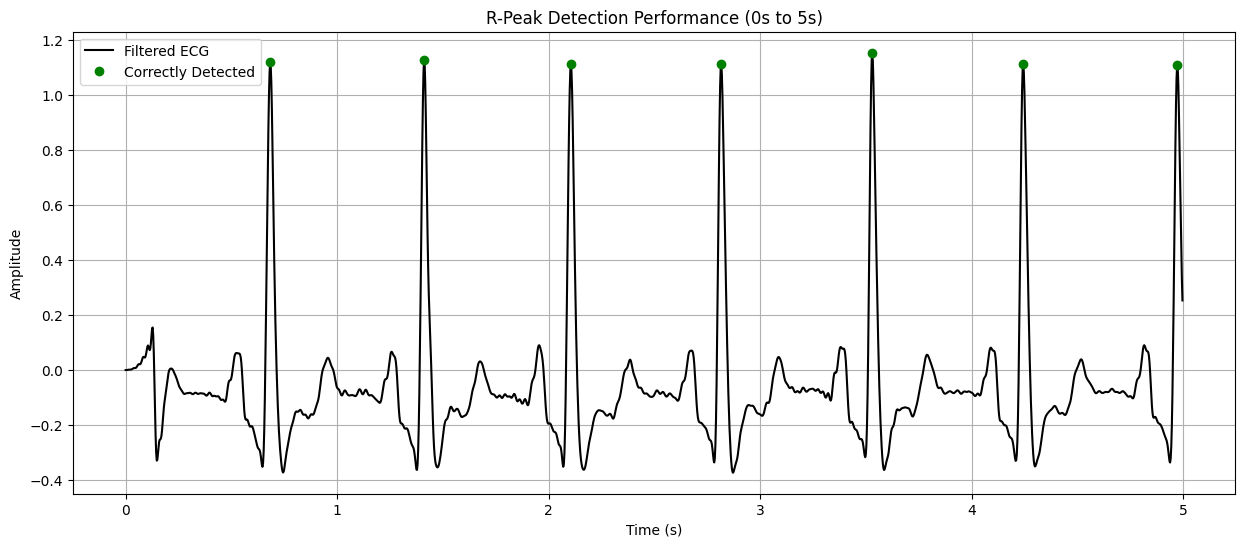

In [30]:
# STEP 1: Load the MIT-BIH annotation file
annotation = wfdb.rdann(record_path, 'atr')

# Get the ground truth R-peaks (annotated as 'N' for normal beats)
true_r_peaks = np.array([annotation.sample[i] for i in range(len(annotation.sample))
                        if annotation.symbol[i] in ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r',
                                                  'F', 'e', 'j', 'n', 'E', 'f', 'Q', '?']])
print(f"Number of ground truth R-peaks: {len(true_r_peaks)}")
print(f"Number of detected R-peaks: {len(r_peaks)}")

# STEP 2: Calculate accuracy metrics with ground truth comparison
def calculate_accuracy_with_ground_truth(detected_peaks, true_peaks, fs, tolerance=0.15):
    """
    Calculate detection accuracy metrics with ground truth comparison.

    Parameters:
    detected_peaks: array of detected peak indices
    true_peaks: array of ground truth peak indices
    fs: sampling rate
    tolerance: time tolerance in seconds for matching peaks

    Returns:
    Dictionary containing accuracy metrics
    """
    tolerance_samples = int(tolerance * fs)
    matched_true = []
    matched_detected = []
    unmatched_true = []
    unmatched_detected = []

    # Find matches between detected and true peaks
    for true_peak in true_peaks:
        matches = np.where(np.abs(detected_peaks - true_peak) <= tolerance_samples)[0]
        if len(matches) > 0:
            matched_true.append(true_peak)
            matched_detected.append(detected_peaks[matches[0]])

    # Find unmatched true peaks
    matched_true_set = set(matched_true)
    unmatched_true = [p for p in true_peaks if p not in matched_true_set]

    # Find unmatched detected peaks
    matched_detected_set = set(matched_detected)
    unmatched_detected = [p for p in detected_peaks if p not in matched_detected_set]

    # Calculate metrics
    TP = len(matched_true)  # True positives
    FN = len(unmatched_true)  # False negatives
    FP = len(unmatched_detected)  # False positives

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    positive_predictivity = TP / (TP + FP) if (TP + FP) > 0 else 0
    detection_error_rate = (FN + FP) / len(true_peaks) if len(true_peaks) > 0 else 0
    accuracy = TP / len(true_peaks) if len(true_peaks) > 0 else 0  # Added accuracy metric

    return {
        'true_positives': TP,
        'false_negatives': FN,
        'false_positives': FP,
        'sensitivity': sensitivity,
        'positive_predictivity': positive_predictivity,
        'detection_error_rate': detection_error_rate,
        'accuracy': accuracy,  # Added accuracy
        'matched_true_peaks': np.array(matched_true),
        'matched_detected_peaks': np.array(matched_detected),
        'unmatched_true_peaks': np.array(unmatched_true),
        'unmatched_detected_peaks': np.array(unmatched_detected)
    }

# Calculate accuracy for R-peak detection
r_peak_accuracy = calculate_accuracy_with_ground_truth(r_peaks, true_r_peaks, fs)

# Print results in a table format
print("\nR-Peak Detection Accuracy Metrics:")
print("--------------------------------")
print(f"True Positives (TP): {r_peak_accuracy['true_positives']}")
print(f"False Negatives (FN): {r_peak_accuracy['false_negatives']}")
print(f"False Positives (FP): {r_peak_accuracy['false_positives']}")
print(f"Accuracy: {r_peak_accuracy['accuracy']:.4f} ({r_peak_accuracy['accuracy']*100:.2f}%)")
print(f"Sensitivity (Se): {r_peak_accuracy['sensitivity']:.4f} ({r_peak_accuracy['sensitivity']*100:.2f}%)")
print(f"Positive Predictivity (+P): {r_peak_accuracy['positive_predictivity']:.4f} ({r_peak_accuracy['positive_predictivity']*100:.2f}%)")
print(f"Detection Error Rate (DER): {r_peak_accuracy['detection_error_rate']:.4f} ({r_peak_accuracy['detection_error_rate']*100:.2f}%)")

# STEP 3: Plot the results with matched and unmatched peaks
def plot_r_peak_comparison(filtered_ecg, r_peak_accuracy, fs, start_time=0, window_duration=5):
    start_idx = int(start_time * fs)
    end_idx = int((start_time + window_duration) * fs)

    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(filtered_ecg))[start_idx:end_idx]/fs,
             filtered_ecg[start_idx:end_idx],
             label="Filtered ECG", color='black')

    # Plot matched R-peaks
    for peak in r_peak_accuracy['matched_detected_peaks']:
        if start_idx <= peak < end_idx:
            plt.plot(peak/fs, filtered_ecg[peak], 'go', label='Correctly Detected' if peak == r_peak_accuracy['matched_detected_peaks'][0] else "")

    # Plot unmatched detected peaks (false positives)
    for peak in r_peak_accuracy['unmatched_detected_peaks']:
        if start_idx <= peak < end_idx:
            plt.plot(peak/fs, filtered_ecg[peak], 'ro', label='False Positive' if peak == r_peak_accuracy['unmatched_detected_peaks'][0] else "")

    # Plot unmatched true peaks (false negatives)
    for peak in r_peak_accuracy['unmatched_true_peaks']:
        if start_idx <= peak < end_idx:
            plt.plot(peak/fs, filtered_ecg[peak], 'bx', markersize=10, label='Missed Detection' if peak == r_peak_accuracy['unmatched_true_peaks'][0] else "")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"R-Peak Detection Performance ({start_time}s to {start_time+window_duration}s)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_r_peak_comparison(filtered_ecg, r_peak_accuracy, fs, start_time=0, window_duration=5)

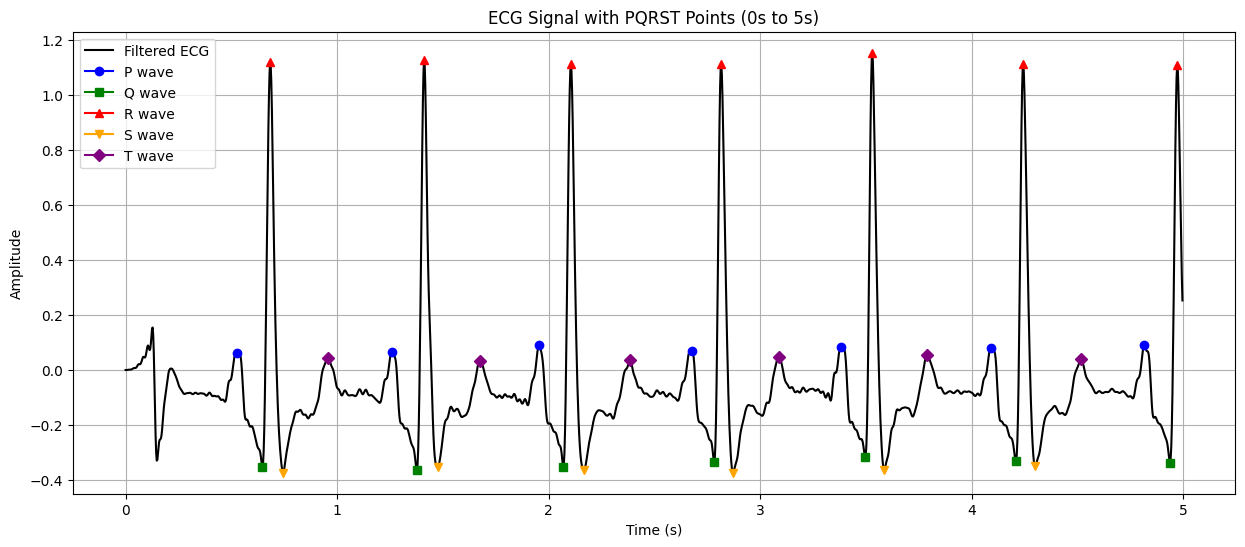

In [31]:
# STEP 7: Plot the results with detected points
def plot_pqrst_segment(filtered_ecg, info, fs, start_time=0, window_duration=5):
    start_idx = int(start_time * fs)
    end_idx = int((start_time + window_duration) * fs)

    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(filtered_ecg))[start_idx:end_idx]/fs,
             filtered_ecg[start_idx:end_idx],
             label="Filtered ECG", color='black')

    colors = {'P': 'blue', 'Q': 'green', 'R': 'red', 'S': 'orange', 'T': 'purple'}
    markers = {'P': 'o', 'Q': 's', 'R': '^', 'S': 'v', 'T': 'D'}

    for wave in ['P', 'Q', 'R', 'S', 'T']:
        key = f'ECG_{wave}_Peaks'
        if key in info and info[key] is not None:
            for peak in info[key]:
                if start_idx <= peak < end_idx:
                    plt.plot(peak/fs, filtered_ecg[peak],
                             marker=markers[wave], color=colors[wave],
                             label=f'{wave} wave' if peak == info[key][0] else "")

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"ECG Signal with PQRST Points ({start_time}s to {start_time+window_duration}s)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_pqrst_segment(filtered_ecg, info, fs, start_time=0, window_duration=5)

In [33]:
import json

# STEP 8: Save PQRST intervals to JSON (for Blender animation)
def save_pqrst_intervals(info, fs):
    pqrst_intervals = []

    # Extract peaks for each wave
    peaks = {wave: [idx / fs for idx in info.get(f'ECG_{wave}_Peaks', [])] for wave in ['P', 'Q', 'R', 'S', 'T']}

    # Ensure all wave peaks are sorted by time
    for wave in peaks:
        peaks[wave].sort()

    # Generate intervals
    for i in range(len(peaks['P'])):  # Iterate through available P waves
        try:
            p_time = peaks['P'][i]
            q_time = peaks['Q'][i]
            r_time = peaks['R'][i]
            s_time = peaks['S'][i]
            t_time = peaks['T'][i]

            # P-Q interval
            pqrst_intervals.append({
                "entry": p_time,
                "duration": q_time - p_time,
                "phase": "PQ"
            })

            # QRS interval
            pqrst_intervals.append({
                "entry": q_time,
                "duration": s_time - q_time,
                "phase": "QRS"
            })

            # S-T interval
            pqrst_intervals.append({
                "entry": s_time,
                "duration": t_time - s_time,
                "phase": "ST"
            })
        except IndexError:
            # Skip if an interval can't be formed (e.g., mismatched wave counts)
            continue

    # Sort by entry time
    pqrst_intervals.sort(key=lambda x: x["entry"])

    # Save to JSON file
    with open('/content/pqrst_intervals.json', 'w') as f:
        json.dump(pqrst_intervals, f, indent=2)

    print("PQRST intervals saved to pqrst_intervals.json")

# Call the function
save_pqrst_intervals(info, fs)


PQRST intervals saved to pqrst_intervals.json
